# Оптимизация производственных процессов плавки стали при помощи машинного обучения

## Описание проекта

В работе рассмотрена задача уменьшения потребления электроэнергии на этапе обработки стали на металлургиеском комбинате. Данная задача решается при помощи построения модели машинного обучения.

**Цель:** построить модель, предсказывающкю конечную температуру стали со средней абсолютной ошибкой (MAE) меньше 6.8 градусов.

**Описание этапа обработки:**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 
Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Описание данных:**

Данные состоят из файлов, полученных из разных источников:

data_arc_new.csv — данные об электродах;

data_bulk_new.csv — данные о подаче сыпучих материалов (объём);

data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);

data_gas_new.csv — данные о продувке сплава газом;

data_temp_new.csv — результаты измерения температуры;

data_wire_new.csv — данные о проволочных материалах (объём);

data_wire_time_new.csv — данные о проволочных материалах (время).

Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

**Краткое описание проделанной работы**

Работа выполнена в 3 этапа:
    
1. Изучение данных.
    
   На этом этапе изучены исходные данные, построены графики, приведены наблюдения. На этом этапе изменения в датафреймы не вносились
    
    
2. Предобработка данных.
    
    Выполнены удаление, заполнение пропусков, генерация новых признаков согласно описанным на первом этапе наблюдениям
    Объединение исходных таблиц в одну по ключу (inner join). Удалены признаки с корреляцией Пирсона больше 0.9. Данные разделены на тренировочную и тестовую выборку в отношении 3:1. Данные смасштабированы, скаллер обучен на обучающих данных. 
    
    
3. Построение моделей и получение метрики на кросс-валидации, выбор лучшей модели и тестирование

    Было рассмотрено 3 модели: CatBoostRegressor, LGBMRegressor и RandomForestRegressor. Для поиска гиперпараметров использовадся GridSearchCV.
        
    Лучшая модель:

        CatBoostRegressor(loss_function="MAE", iterations=500, random_state=280823, depth=3, learning_rate=0.1)
        
    Метрика R2 лучшей модели равна 0.45, что означает что модель лучше константной модели
    
    Метрика MAE лучшей модели на тестовой выборке 6.13, что лучше целевого значения 
    
    Также проведено исследование важности признаков. Наиболее важные признаки: продолжительность нагреваа (более 30%) и начальная температура (около 22%)


## Изучение данных

In [2]:
!pip install catboost --quiet
!pip install lightgbm --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

RANDOM_STATE = 280823

In [4]:
# Напишем функцию для первичной проверки данных
def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    #print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)

In [37]:
#загружаем исходные данные
try:                    
    data_arc = pd.read_csv('/datasets/data_arc_new.csv')
    data_bulk = pd.read_csv('/datasets/data_bulk_new.csv') 
    data_bulk_time = pd.read_csv('/datasets/data_bulk_time_new.csv') 
    data_gas = pd.read_csv('/datasets/data_gas_new.csv') 
    data_temp = pd.read_csv('/datasets/data_temp_new.csv') 
    data_wire = pd.read_csv('/datasets/data_wire_new.csv') 
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv') 


### Данные об электродах (data_arc)

In [38]:
check_data(data_arc)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.662752,0.258885,0.223120,0.467115,0.599587,0.830070,1.463773
Реактивная мощность,14876.0,0.438986,5.873485,-715.479924,0.337175,0.441639,0.608201,1.270284


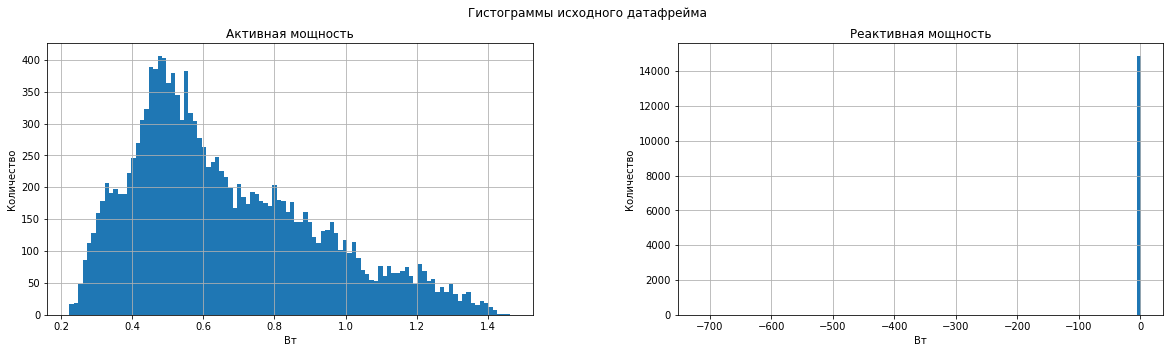

In [39]:
fig,axs = plt.subplots(1,2,figsize=(20,5))
data_arc.drop('key', axis = 1).hist(bins=100, ax=axs)
for ax in axs.flat:
    ax.set(ylabel='Количество', xlabel='Вт')
plt.suptitle('Гистограммы исходного датафрейма')
plt.show()

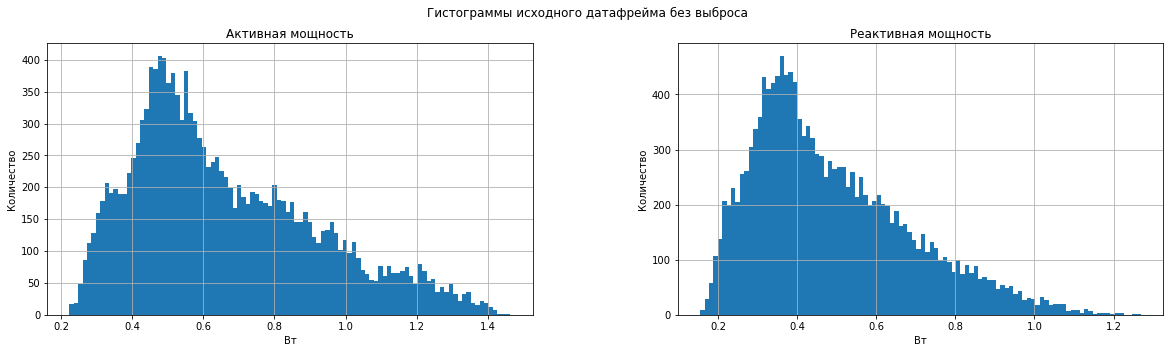

In [40]:
# Не меняя сам датафрейм отобразим данные без выброса
fig,axs = plt.subplots(1,2,figsize=(20,5))
data_arc[data_arc['Реактивная мощность'] > 0].drop('key', axis = 1).hist(bins=100, ax=axs)
for ax in axs.flat:
    ax.set(ylabel='Количество', xlabel='Вт')
plt.suptitle('Гистограммы исходного датафрейма без выброса')
plt.show()

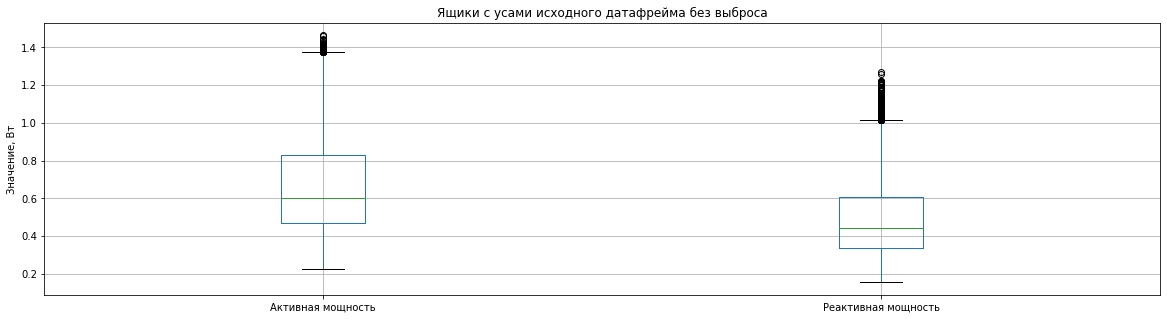

In [41]:
data_arc[data_arc['Реактивная мощность'] > 0].drop('key', axis = 1).boxplot(figsize = (20,5))
plt.title('Ящики с усами исходного датафрейма без выброса')
plt.ylabel('Значение, Вт')
plt.show()

**Наблюдения:**

Названия столбцов написаны на русском, но они мне нравятся и, поскольку это было дозволено на вебинаре, менять их в этом проекте не буду

Пропусков и дубликатов в данных нет. Наблюдается один явный выброс в столбце "Реактивная мощность", его надо будет удалить.

Можно будет создать новые признаки: продолжительность нагрева (разность столбцов с началом и концом, для итоговой таблицы в которой строка соответствует одному ковшу, необходимо будет сложить все промежутки нагрева для конкретного ковша), полная мощность (равна корню квадратному из суммы квадратов активной и реактивной мощностей), энергия (равна произведению времени нагрева на полную мощность)


Чтобы не переписывать сюда википедию, оставлю ссылку на нее
https://ru.wikipedia.org/wiki/%D0%AD%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D0%BC%D0%BE%D1%89%D0%BD%D0%BE%D1%81%D1%82%D1%8C

### Данные об объеме сыпучих материалов (data_bulk)

In [42]:
check_data(data_bulk)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB
None

Проверка пропусков
Количество пропусков: 35776
Доля пропусков: 76.2%
Доля строк содержащих пропуски: 100.0%

Проверка на дублик

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
Bulk 1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
Bulk 2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
Bulk 3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
Bulk 4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
Bulk 5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
Bulk 6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
Bulk 7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
Bulk 8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
Bulk 9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


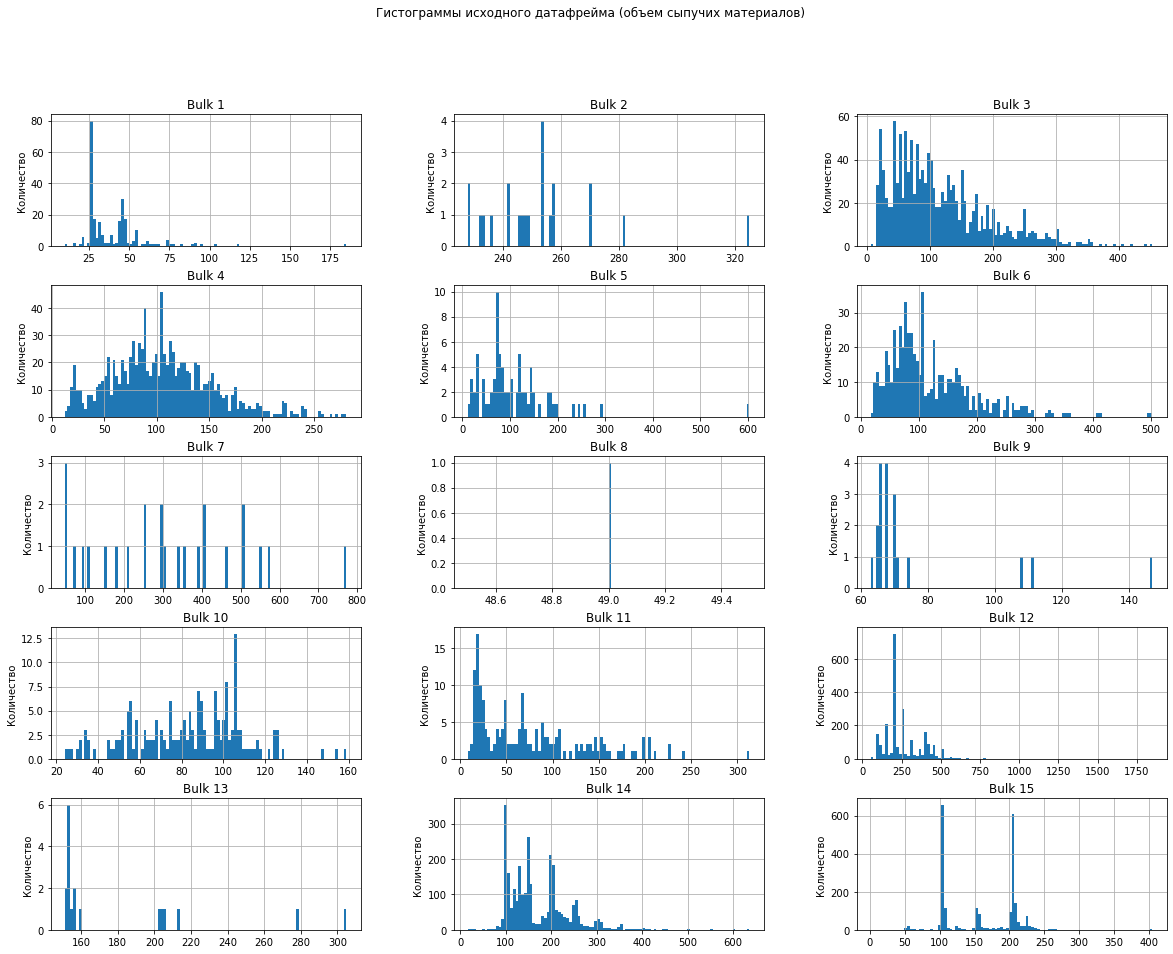

In [43]:
fig,axs = plt.subplots(5,3,figsize=(20,15))
plt.suptitle('Гистограммы исходного датафрейма (объем сыпучих материалов)')
data_bulk.drop('key', axis = 1).hist(bins=100, ax=axs)
for ax in axs.flat:
    ax.set(ylabel='Количество')
plt.show()

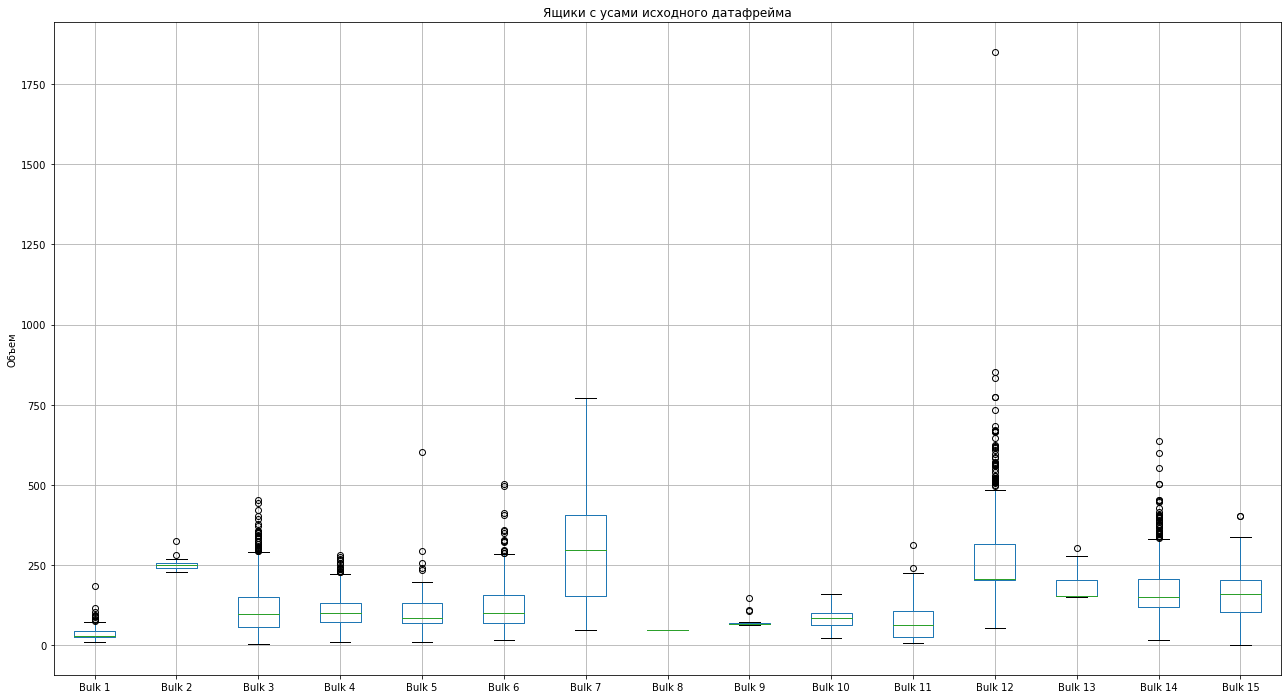

In [44]:
data_bulk.drop('key', axis = 1).boxplot(figsize = (22,12))
plt.title('Ящики с усами исходного датафрейма')
plt.ylabel('Объем')
plt.show()

**Наблюдения**

дубликатов нет, пропусков очень много. Пропуск означает, что материал в сплаве не используется, поэтому их все можно заменить на 0. 

Весь ковш с материалом "Bulk 8" надо будет удалить, так как материал встречается лишь однажды и только помешает обучению. Другие материалы которые встречаются редко можно оставить как есть или объединить в один

На ящиках с усами видны выбросы, но удалять ничего не будем, потому что это скорее реальные значения, а не ошибки в данных и модель должна учитывать такие аномалии

### Время подачи сыпучих материалов (data_bulk_time)

In [45]:
check_data(data_bulk_time)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB
None

Проверка пропусков
Количество пропусков: 35776
Доля пропусков: 76.2%
Доля строк содержащих пропуски: 100.0%

Проверка на дубликаты
Количество пол

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


**Наблюдения**

Можно проверить соответствуют ли пропуски в этой таблице пропускам в таблице 'data_bulk'. Если нет, то это ошибка и данные для таких ковшей лучше удалить

В итоговой таблице данные из таблицы 'data_bulk_time' использовать не будем

### Данные об объеме проволочных материалов (data_wire)

In [46]:
check_data(data_wire)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB
None

Проверка пропусков
Количество пропусков: 23385
Доля пропусков: 84.3%
Доля строк содержащих пропуски: 100.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
Wire 1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
Wire 2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
Wire 3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
Wire 4,14.0,57.442842,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
Wire 5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
Wire 7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
Wire 8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
Wire 9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


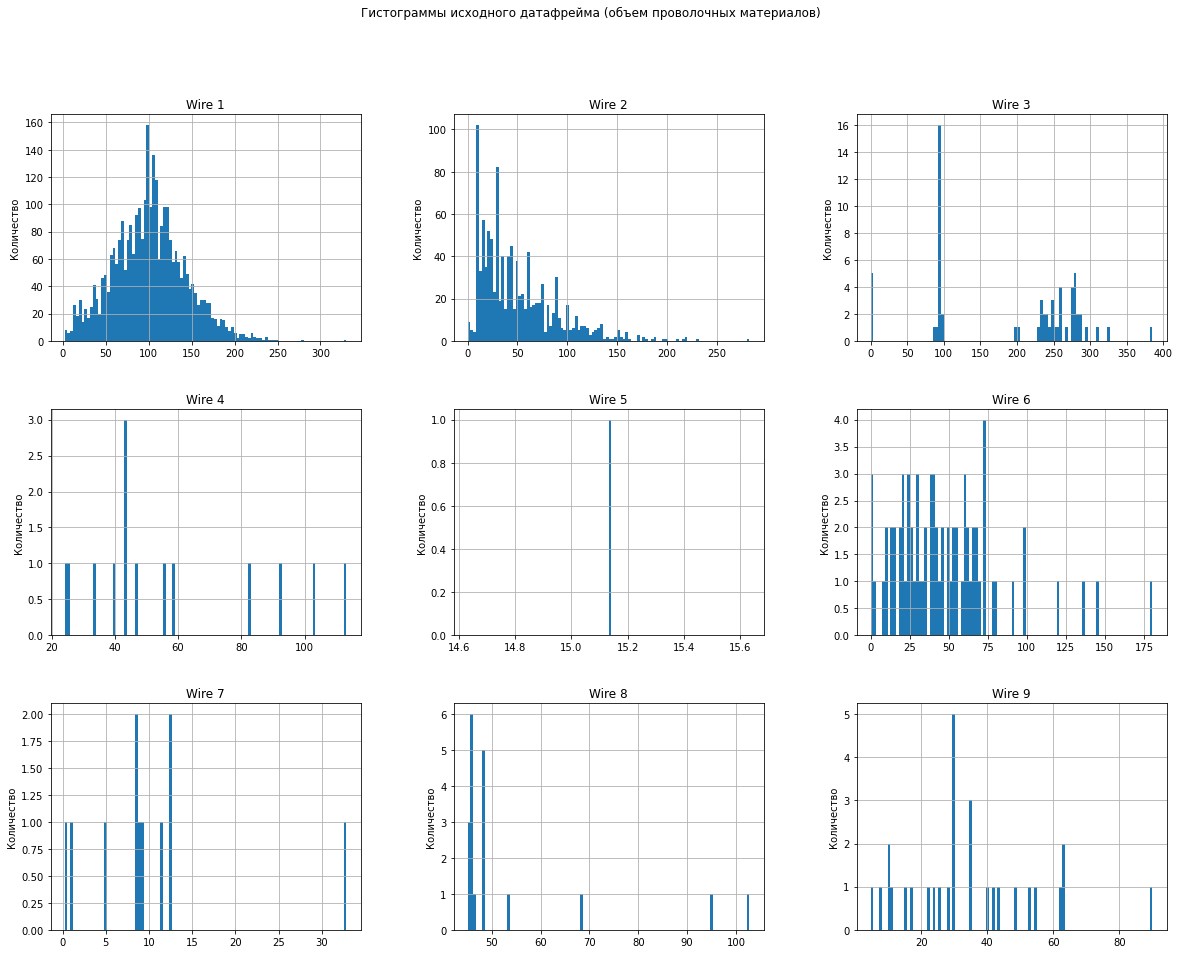

In [47]:
fig,axs = plt.subplots(3,3,figsize=(20,15))
plt.suptitle('Гистограммы исходного датафрейма (объем проволочных материалов)')
data_wire[data_wire.select_dtypes(exclude=['int64']).columns].hist(bins =100, ax=axs)
for ax in axs.flat:
    ax.set(ylabel='Количество')
plt.show()

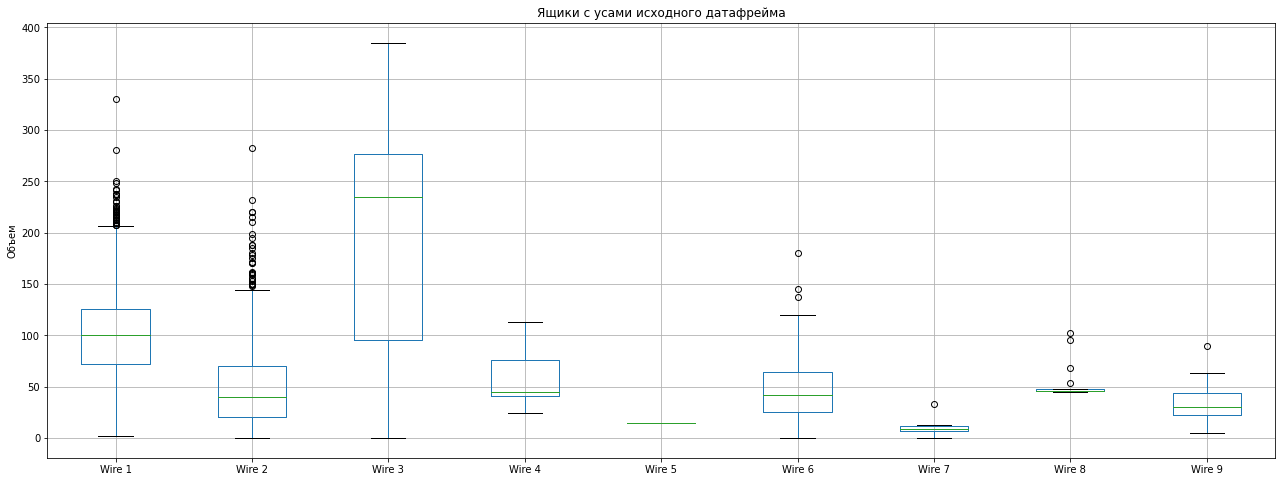

In [48]:
data_wire[data_wire.select_dtypes(exclude=['int64']).columns].boxplot(figsize = (22,8))
plt.title('Ящики с усами исходного датафрейма')
plt.ylabel('Объем')
plt.show()

Аналогично сыпучим материалам удалим ковш с материалом Wire 5

### Данные о времени подачи проволочных материалов (data_wire_time)

In [49]:
check_data(data_wire_time)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB
None

Проверка пропусков
Количество пропусков: 23385
Доля пропусков: 84.3%
Доля строк содержащих пропуски: 100.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


Аналогично сыпучим материалам не используем эту таблицу

### Данные о продувке сплава газом (data_gas)

In [50]:
check_data(data_gas)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB
None

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


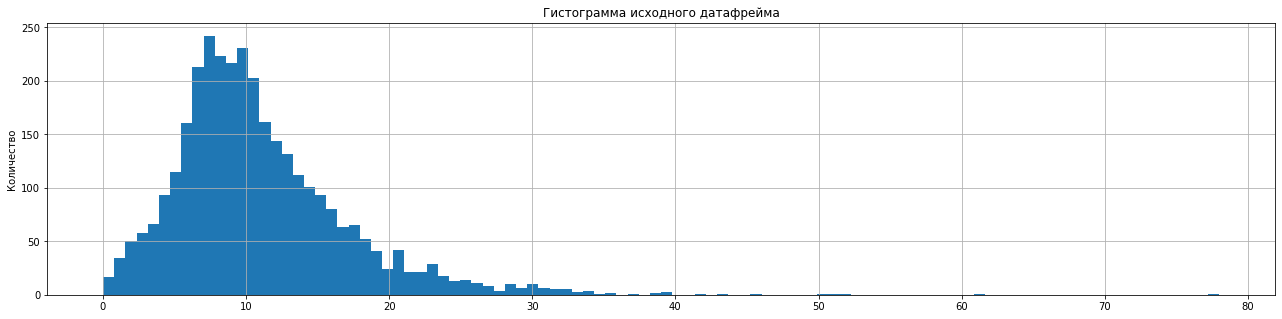

In [51]:
data_gas['Газ 1'].hist(figsize = (22,5),bins =100)
plt.title('Гистограмма исходного датафрейма')
plt.ylabel('Количество')
plt.show()

**Наблюдения**

Пропусков, дубликатов и явных выбросов нет. Нужно будет подробнее почитать про процесс выплавки и посмотреть корреляции с другими признаками, возможно можно будет попробовать обучить модель без этого признака.

### Данные измерений температуры (data_temp)

In [52]:
check_data(data_temp)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB
None

Проверка пропусков
Количество пропусков: 3427
Доля пропусков: 9.5%
Доля строк содержащих пропуски: 18.9%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,18092.0,1616.460977,934.641385,1.0,807.75,1618.0,2429.0,3241.0
Температура,14665.0,1590.722741,20.394381,1191.0,1580.00,1590.0,1599.0,1705.0


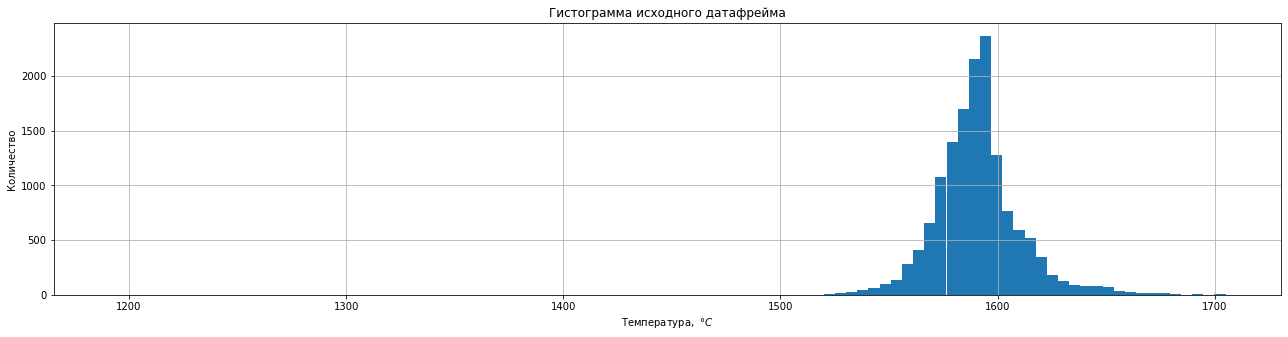

In [53]:
data_temp['Температура'].hist(figsize = (22,5),bins =100)
plt.title('Гистограмма исходного датафрейма')
plt.ylabel('Количество')
plt.xlabel('Температура,  $\degree C$')
plt.show()

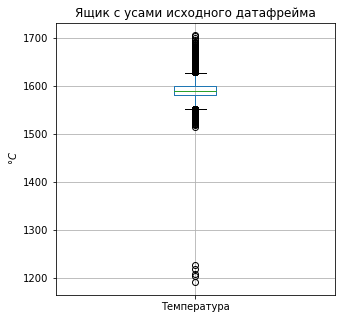

In [54]:
data_temp.boxplot(column=['Температура'], figsize = (5,5))
plt.title('Ящик с усами исходного датафрейма')
plt.ylabel(' $\degree C$')
plt.show()

**Наблюдения**

Дубликатов нет, строк с пропусками почти 19%. 

Нкжно будет удалить ковши, данные для которых представлены с явными ошиками. Температура плавления стали не должна быть ниже 1300 градусов. Ошибки хорошо видно на ящике с усами

Нужно будет удалить все такие ковши, для которых нет данных о начальной или о конечной температуре. Проверить нет ли ковшей только с одним измерением и удалить такие, если они есть. 


## Предобработка данных

### Данные об электродах (data_arc)

In [55]:
#посмотрим на нереалистичные значения
data_arc[data_arc['Реактивная мощность'] <= 0]

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


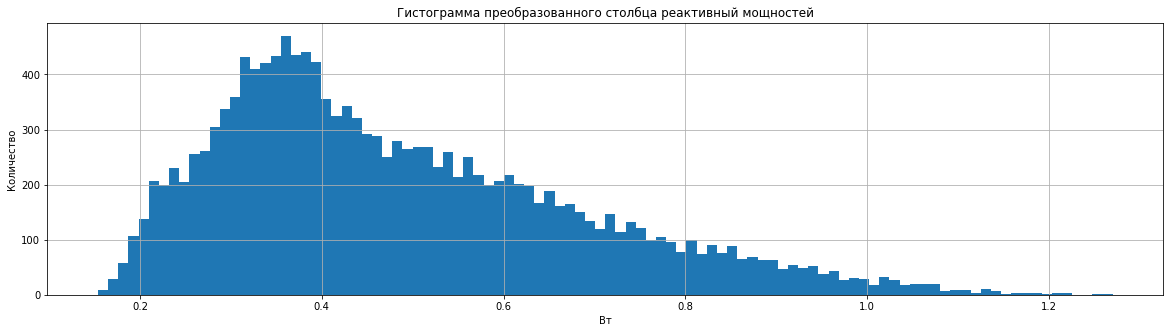

In [56]:
# удалим ключ с ошибкой
data_arc = data_arc[data_arc['key'] != 2116]
data_arc['Реактивная мощность'].hist(bins=100,figsize=(20,5))
plt.ylabel('Количество')
plt.xlabel('Вт')
plt.title('Гистограмма преобразованного столбца реактивный мощностей')
plt.show()

In [57]:
# преобразуем в формат даты начало и конец нагрева
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14872 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14872 non-null  int64         
 1   Начало нагрева дугой  14872 non-null  datetime64[ns]
 2   Конец нагрева дугой   14872 non-null  datetime64[ns]
 3   Активная мощность     14872 non-null  float64       
 4   Реактивная мощность   14872 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 697.1 KB


In [58]:
#создадим новые признаки согласно плану
data_arc['dutarion'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой'])/pd.Timedelta('1s')
data_arc['full_power'] = (data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)**(1/2) 
data_arc['energy'] = data_arc['full_power'] * data_arc['dutarion']
data_arc.head(6)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,dutarion,full_power,energy
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.371123,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.902319,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.722536,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.642824,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,1.079934,159.830252
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351,137.0,0.440239,60.312695


In [59]:
#сгруппируем данные по ключам
#время и энергию просуммируем, а мощность думаю лучше вычислить как отношение энергии к времени
#суммирование мощностей как единиц энергии в секунду будет нефизичным
data_arc_agg = pd.DataFrame()
data_arc_agg['energy'] = data_arc.groupby('key')['energy'].sum()
data_arc_agg['dutarion'] = data_arc.groupby('key')['dutarion'].sum()
data_arc_agg['avg_power'] = data_arc_agg['energy'] / data_arc_agg['dutarion']
data_arc_agg.head()

,energy,dutarion,avg_power
key,,,
1,770.282114,1098.0,0.701532
2,481.760005,811.0,0.594032
3,722.837668,655.0,1.103569
4,683.455597,741.0,0.922342
5,512.169934,869.0,0.589379


In [60]:
data_arc_agg.shape

(3213, 3)

### Данные о материалах

In [61]:
# удалим единожды встречающийся материал и заполним пропуски согласно плану
data_bulk = data_bulk.drop('Bulk 8',axis=1).fillna(0)
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [62]:
# удалим единожды встречающийся материал и заполним пропуски согласно плану
data_wire = data_wire.drop('Wire 5',axis=1).fillna(0)
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0


### Данные о температуре

In [63]:
data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


In [64]:
#найдем ключи с нереалисстичными значениями температур
err_keys = data_temp[data_temp['Температура'] <= 1300]['key'].to_list()
err_keys

[867, 1214, 1619, 2052, 2561]

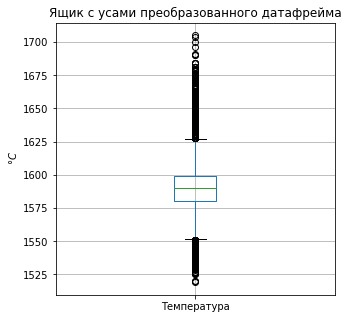

In [65]:
#удалим ключи с нереалисстичными значениями температур 
data_temp = data_temp[~data_temp['key'].isin(err_keys)]
data_temp.boxplot(column=['Температура'], figsize = (5,5))
plt.title('Ящик с усами преобразованного датафрейма')
plt.ylabel(' $\degree C$')
plt.show()

In [66]:
# найдем ключи с пропусками в значении температур
err_keys = data_temp[data_temp['Температура'].isna()]['key'].to_list()
len(err_keys)

3422

In [67]:
# удалим ключи с пропусками в значении температур
data_temp = data_temp[~data_temp['key'].isin(err_keys)]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13905 non-null  int64         
 1   Время замера  13905 non-null  datetime64[ns]
 2   Температура   13905 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 434.5 KB


In [68]:
data_temp.head(7)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0


In [72]:
# нам нужно оставить первый и последний замеры температуры
data_temp_agg = data_temp.groupby('key').agg(["first", "last"])
data_temp_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2473 entries, 1 to 2499
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   (Время замера, first)  2473 non-null   datetime64[ns]
 1   (Время замера, last)   2473 non-null   datetime64[ns]
 2   (Температура, first)   2473 non-null   float64       
 3   (Температура, last)    2473 non-null   float64       
dtypes: datetime64[ns](2), float64(2)
memory usage: 96.6 KB


In [73]:
data_temp_agg.columns = ['Время замера_x', 'Время замера_y','Температура_x','Температура_y']

In [76]:
# добавим новый признак: время между замерами (возможно он будет коррелировать в временем нагрева электродов - проверим)
data_temp_agg['time'] = (data_temp_agg['Время замера_y'] - data_temp_agg['Время замера_x'])/pd.Timedelta('1s')
data_temp_agg.head()

,Время замера_x,Время замера_y,Температура_x,Температура_y,time
key,,,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,1571.0,1613.0,1714.0
2,2019-05-03 11:34:04,2019-05-03 11:55:09,1581.0,1602.0,1265.0
3,2019-05-03 12:06:44,2019-05-03 12:35:57,1596.0,1599.0,1753.0
4,2019-05-03 12:39:27,2019-05-03 12:59:47,1601.0,1625.0,1220.0
5,2019-05-03 13:11:03,2019-05-03 13:36:39,1576.0,1602.0,1536.0


In [77]:
# если время замера первой и последней температуры совпадают, то в исходных данных был лтолько один замер
# удалим такие ключи
data_temp_agg = data_temp_agg[data_temp_agg['time'] != 0]
data_temp_agg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2471 entries, 1 to 2499
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Время замера_x  2471 non-null   datetime64[ns]
 1   Время замера_y  2471 non-null   datetime64[ns]
 2   Температура_x   2471 non-null   float64       
 3   Температура_y   2471 non-null   float64       
 4   time            2471 non-null   float64       
dtypes: datetime64[ns](2), float64(3)
memory usage: 115.8 KB


In [78]:
# удалим столцы с точным временем, оставим только интересующие нас признаки
data_temp_agg = data_temp_agg.drop(['Время замера_x', 'Время замера_y'], axis=1)
data_temp_agg.head()

,Температура_x,Температура_y,time
key,,,
1,1571.0,1613.0,1714.0
2,1581.0,1602.0,1265.0
3,1596.0,1599.0,1753.0
4,1601.0,1625.0,1220.0
5,1576.0,1602.0,1536.0


## Объединение таблиц и исследование объединенной таблицы

In [79]:
# объединяем таблицы по ключу
data = data_arc_agg.merge(data_bulk, on='key', how='inner')
data = data.merge(data_wire, on='key', how='inner')
data = data.merge(data_gas, on='key', how='inner')
data = data.merge(data_temp_agg, on='key', how='inner')

# выводим информацию о таблицу
check_data(data)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            2324 non-null   int64  
 1   energy         2324 non-null   float64
 2   dutarion       2324 non-null   float64
 3   avg_power      2324 non-null   float64
 4   Bulk 1         2324 non-null   float64
 5   Bulk 2         2324 non-null   float64
 6   Bulk 3         2324 non-null   float64
 7   Bulk 4         2324 non-null   float64
 8   Bulk 5         2324 non-null   float64
 9   Bulk 6         2324 non-null   float64
 10  Bulk 7         2324 non-null   float64
 11  Bulk 9         2324 non-null   float64
 12  Bulk 10        2324 non-null   float64
 13  Bulk 11        2324 non-null   float64
 14  Bulk 12        2324 non-null   float64
 15  Bulk 13        2324 non-null   float64
 16  Bulk 14        2324 non-null   float64
 17  Bulk 15        2324 non-null 

,key,energy,dutarion,avg_power,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,...,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1,Температура_x,Температура_y,time
0,1,770.282114,1098.0,0.701532,0.0,0.0,0.0,43.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,29.749986,1571.0,1613.0,1714.0
1,2,481.760005,811.0,0.594032,0.0,0.0,0.0,73.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,12.555561,1581.0,1602.0,1265.0
2,3,722.837668,655.0,1.103569,0.0,0.0,0.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,28.554793,1596.0,1599.0,1753.0
3,4,683.455597,741.0,0.922342,0.0,0.0,0.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,18.841219,1601.0,1625.0,1220.0
4,5,512.169934,869.0,0.589379,0.0,0.0,0.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.413692,1576.0,1602.0,1536.0



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
key,2324.0,1251.140275,715.027927,1.000000,628.750000,1254.500000,1867.250000,2499.000000
energy,2324.0,670.232396,319.526707,33.430208,457.924990,631.228863,841.824214,4546.405812
dutarion,2324.0,808.196644,340.813828,57.000000,581.000000,778.000000,993.000000,4189.000000
avg_power,2324.0,0.826557,0.174406,0.331897,0.697521,0.811669,0.935241,1.567715
Bulk 1,2324.0,3.435026,12.424463,0.000000,0.000000,0.000000,0.000000,185.000000
Bulk 2,2324.0,1.425559,19.102530,0.000000,0.000000,0.000000,0.000000,325.000000
Bulk 3,2324.0,47.317126,75.238050,0.000000,0.000000,0.000000,80.000000,454.000000
Bulk 4,2324.0,37.347676,58.677890,0.000000,0.000000,0.000000,77.250000,281.000000
Bulk 5,2324.0,2.645869,22.426054,0.000000,0.000000,0.000000,0.000000,603.000000
Bulk 6,2324.0,22.419535,55.792509,0.000000,0.000000,0.000000,0.000000,503.000000


Как ожидалось, пропусков и дцбликатов в данных нет. Графики для исходных признаков представлены выше на первом этапе работы. Изучим сгенерированные признаки ('duration' у меня 'dutarion' - как в начале опечатался и не замеетил так и тянется)

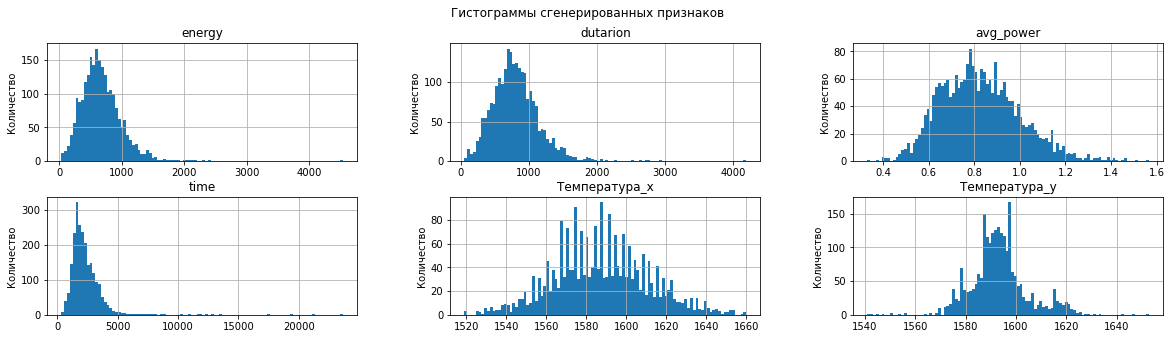

In [80]:
# Не меняя сам датафрейм отобразим данные без выброса
fig,axs = plt.subplots(2,3,figsize=(20,5))
data[['energy','dutarion','avg_power', 'time','Температура_x','Температура_y']].hist(bins=100, ax=axs)
for ax in axs.flat:
    ax.set(ylabel='Количество')
plt.suptitle('Гистограммы сгенерированных признаков')
plt.show()

Гистограммы выглядят ожидаемо. Есть температуры, которые встречаются чаще других (такие "столбики" на графике начальной температуры), что связано скорее всего в тех процессом

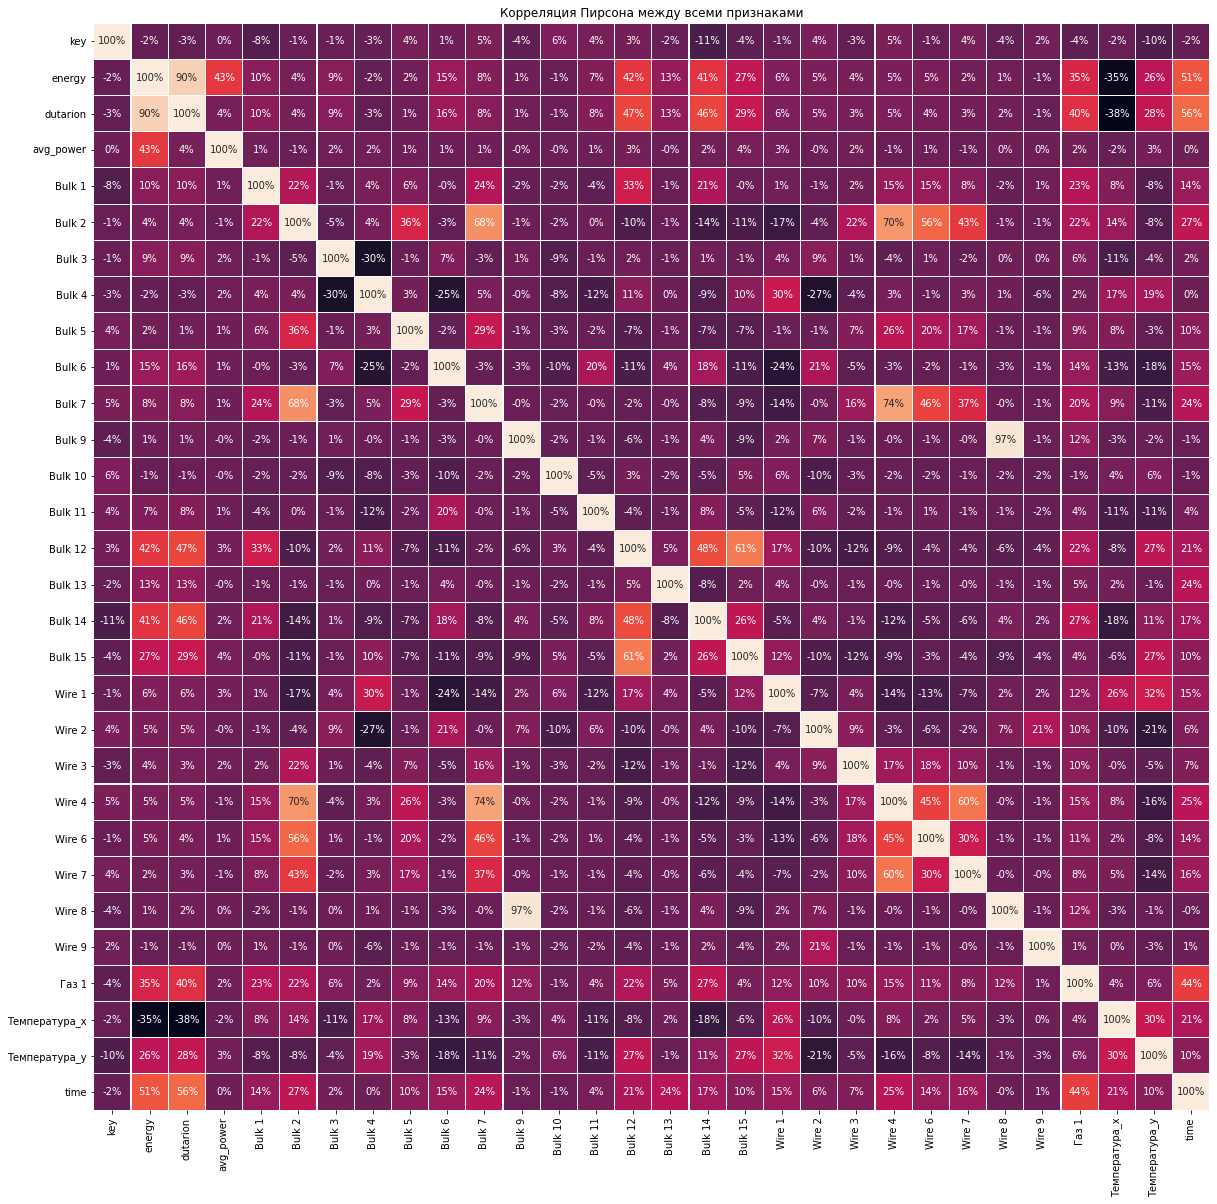

In [45]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), ax=ax, annot = True, fmt='.0%',cbar=False, linewidth=0.1)
plt.title('Корреляция Пирсона между всеми признаками')
plt.show()

In [81]:
# удаляем кореллирующие признаки и номер ключа
data = data.drop(['energy','Wire 8','key'], axis=1)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dutarion       2324 non-null   float64
 1   avg_power      2324 non-null   float64
 2   Bulk 1         2324 non-null   float64
 3   Bulk 2         2324 non-null   float64
 4   Bulk 3         2324 non-null   float64
 5   Bulk 4         2324 non-null   float64
 6   Bulk 5         2324 non-null   float64
 7   Bulk 6         2324 non-null   float64
 8   Bulk 7         2324 non-null   float64
 9   Bulk 9         2324 non-null   float64
 10  Bulk 10        2324 non-null   float64
 11  Bulk 11        2324 non-null   float64
 12  Bulk 12        2324 non-null   float64
 13  Bulk 13        2324 non-null   float64
 14  Bulk 14        2324 non-null   float64
 15  Bulk 15        2324 non-null   float64
 16  Wire 1         2324 non-null   float64
 17  Wire 2         2324 non-null   float64
 18  Wire 3  

Предобработка данных на этом завершена

## Обучение моделей

In [84]:
# выделяем целевой признак
features = data.drop(['Температура_y'], axis=1)
target = data['Температура_y']

# разобъем данные на выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE)
print('train:',  features_train.shape, target_train.shape)
print('test:',  features_test.shape, target_test.shape)

train: (1743, 26) (1743,)
test: (581, 26) (581,)


In [85]:
# масштабируем данные
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test) 

### CatBoost

In [86]:
param = {'depth': [3,5,7], 'learning_rate': [0.01, 0.1, 0.3]}

estimator = CatBoostRegressor(loss_function="MAE", iterations=500, random_state=RANDOM_STATE)

#подбор параметров и обучение
cat_boost = GridSearchCV(estimator=estimator, param_grid=param,cv=5, n_jobs=4, scoring='neg_mean_absolute_error')
cat_boost.fit(features_train, target_train, verbose=20)

# Результат
print('Параметры:', cat_boost.best_params_)
print('MSE:', cat_boost.best_score_*(-1))

0:	learn: 7.8481344	total: 138ms	remaining: 1m 8s
20:	learn: 6.5723911	total: 188ms	remaining: 4.29s
40:	learn: 6.0514323	total: 234ms	remaining: 2.62s
60:	learn: 5.7508062	total: 276ms	remaining: 1.99s
80:	learn: 5.5535320	total: 320ms	remaining: 1.66s
100:	learn: 5.3961976	total: 374ms	remaining: 1.48s
120:	learn: 5.2675981	total: 416ms	remaining: 1.3s
140:	learn: 5.1518804	total: 461ms	remaining: 1.17s
160:	learn: 5.0590037	total: 506ms	remaining: 1.06s
180:	learn: 4.9794602	total: 549ms	remaining: 968ms
200:	learn: 4.9107719	total: 606ms	remaining: 902ms
220:	learn: 4.8308770	total: 654ms	remaining: 826ms
240:	learn: 4.7573251	total: 694ms	remaining: 746ms
260:	learn: 4.6867088	total: 740ms	remaining: 678ms
280:	learn: 4.6376302	total: 788ms	remaining: 614ms
300:	learn: 4.5883752	total: 849ms	remaining: 561ms
320:	learn: 4.5496528	total: 891ms	remaining: 497ms
340:	learn: 4.5042237	total: 951ms	remaining: 443ms
360:	learn: 4.4546984	total: 1s	remaining: 387ms
380:	learn: 4.4195169	

### LGBMRegressor

In [87]:
param = {'learning_rate': [0.01, 0.1, 0.3],'n_estimators': [10, 50, 500]}

estimator = LGBMRegressor(random_state=RANDOM_STATE)

#подбор параметров и обучение
lgbm = GridSearchCV(estimator=estimator, param_grid=param,cv=5, n_jobs=4, scoring='neg_mean_absolute_error')
lgbm.fit(features_train, target_train)

# Результат
print('Параметры:', lgbm.best_params_)
print('MAE:', lgbm.best_score_*(-1))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2443
[LightGBM] [Info] Number of data points in the train set: 1743, number of used features: 19
[LightGBM] [Info] Start training from score 1593.406196
Параметры: {'learning_rate': 0.01, 'n_estimators': 500}
MAE: 5.834685859414711


### Случайный лес

In [88]:
param = {'max_depth': [10, 150],'n_estimators': [10, 20, 100]}

estimator = RandomForestRegressor(random_state=RANDOM_STATE)

#подбор параметров и обучение
forest = GridSearchCV(estimator=estimator, param_grid=param,cv=5, scoring='neg_mean_absolute_error')
forest.fit(features_train, target_train)

# Результат
print('Параметры:', forest.best_params_)
print('MAE:', forest.best_score_*(-1))

Параметры: {'max_depth': 150, 'n_estimators': 100}
MAE: 5.995327009847513


**Промежууточный вывод:**

1. На обучающей выборке все модели показали MAE < 6.

2. Лучшая модель : CatBoost


## Тестирование лучшей модели

In [89]:
#предсказания
predictions = cat_boost.best_estimator_.predict(features_test)

# MAE модели на тестовой выборке
mean_absolute_error(target_test, predictions)

6.131233693938068

In [90]:
# исследуем метрику R2 
r2_score(target_test, predictions)

0.4483466107707882

Коэффициент детерминации 0.45. Не идеально, но значение положительно, а значит модель работает лучше константной модели. Получается код в следующей ячейке можно было не писать 


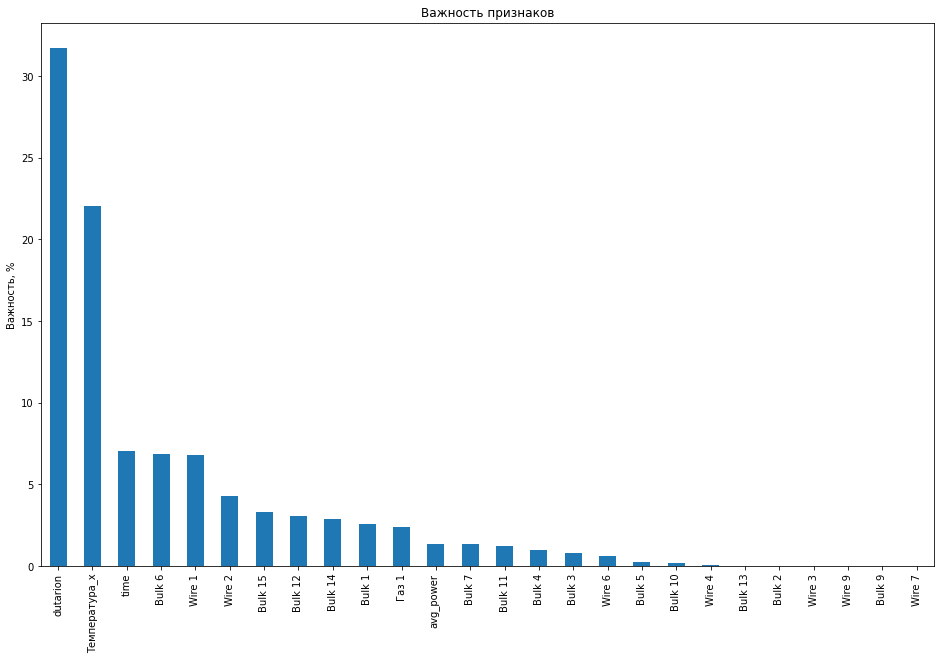

In [57]:
# исследуем важность признаков
importance = pd.Series(cat_boost.best_estimator_.get_feature_importance(),features.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(16,10))
importance.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
plt.show()

**Выводы по моделям:**

1. Цель достигнута: лучшая модель CatBoost на тестовой выборке показывает **MAE 6.13**

2. Метрика R2 лучшей модели равна 0.45, что означает что модель лучше константной модели

3. Наиболее важные признаки: продолжительность нагреваа (более 30%) и начальная температура (около 22%)

**Для дальнейшей работы. Что можно улучшить:**

-Использовать больше гиперпараметров, RandomizedSearchCV 

-Обучить модель без учета неважных признаков.